# Giai đoạn 5 – RandomForest (Full feature set)

Hyperparams: 100 trees, depth=10, min_split=5, min_leaf=2, class_weight=balanced.  
Acc ≈ 0.92 ± 0.029.  
Ưu: Feature importance trực quan.  
Nhược: Hơi kém SVM/XGBoost ~1%, model size lớn hơn SVM.  
Vai trò: Tham chiếu cây để kiểm tra đóng góp đặc trưng.

# Tiền xử lý ảnh
+ Tái sử dụng cùng bộ hàm như SVM/XGBoost full
+ _prep_gray(): grayscale + downscale >700k + medianBlur(3).
+ OCR: adaptiveThreshold (21,8) + hybrid SequenceMatcher/Jaccard.
+ Histogram: 32 bins / kênh không chia vùng.
+ ORB: gray trực tiếp (không resize cứng).
+ Layout: Canny IoU.
+ Không scaler (RF tree-based)

In [5]:
import cv2, os, re, numpy as np
from skimage.metrics import structural_similarity as ssim
import pytesseract
from difflib import SequenceMatcher
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import GroupKFold
from sklearn.metrics import classification_report, confusion_matrix

pytesseract.pytesseract.tesseract_cmd = r'D:\Apps\Tesseract-OCR\tesseract.exe'

def load_cases():
    mapping = {'identical':'similar','text_changes':'almost','layout_changes':'almost',
               'changes':'different','completely_different':'different'}
    cases, groups = [], []
    ori_dir = "Pictures_VisualTesting/original_image/"
    var_dir = "Pictures_VisualTesting/variant_image/"

    for f in os.listdir(ori_dir):
        m = re.search(r'original_(\d+)', f)
        if not m: continue
        group_id = int(m.group(1))
        vidir = os.path.join(var_dir, f"original_{m.group(1)}")
        if not os.path.isdir(vidir): continue
        for vf in os.listdir(vidir):
            label = mapping.get(vf.split('.')[0].lower())
            if label: 
                cases.append((os.path.join(ori_dir,f), os.path.join(vidir,vf), label))
                groups.append(group_id)
    return cases, groups

class FeatureRandomForest:
    def __init__(self):
        self.model = RandomForestClassifier(
            n_estimators=100,        
            max_depth=10,           
            min_samples_split=5,    
            min_samples_leaf=2,     
            random_state=42,       
            class_weight='balanced',
            n_jobs=-1             
        )
        
        self.orb = cv2.ORB_create(nfeatures=150)
        self.map = {'similar':0,'almost':1,'different':2}
        self.names = ['Similar','Almost','Different']
        self._ocr_cache = {}

    def _prep_gray(self, img):
        g=cv2.imread(img, cv2.IMREAD_GRAYSCALE)
        if g is None: return None
        max_pixels=700_000
        h,w=g.shape
        if h*w>max_pixels:
            s=(max_pixels/(h*w))**0.5
            g=cv2.resize(g,(int(w*s), int(h*s)))
        g=cv2.medianBlur(g,3)
        return g

    def f_ssim(self, a, b):
        try:
            g1 = self._prep_gray(a); g2 = self._prep_gray(b)
            return ssim(g1, g2, data_range=255)
        except:
            return 0.5

    def f_ocr(self,a,b):
        def gw(p,gimg):
            if p in self._ocr_cache: return self._ocr_cache[p]
            bw=cv2.adaptiveThreshold(gimg,255,cv2.ADAPTIVE_THRESH_MEAN_C,
                                     cv2.THRESH_BINARY,21,8)
            txt=pytesseract.image_to_string(bw, config="--oem 3 --psm 6")
            ws=re.sub(r'[^A-Za-z0-9 ]+',' ',txt).lower().split()
            self._ocr_cache[p]=ws
            return ws
        try:
            g1=self._prep_gray(a); g2=self._prep_gray(b)
            if g1 is None or g2 is None: return 0.5
            t1=gw(a,g1); t2=gw(b,g2)
            if len(t1)<3 and len(t2)<3: return 0.8
            if len(t1)==0 or len(t2)==0: return 0.3
            sm=SequenceMatcher(None,' '.join(t1),' '.join(t2)).ratio()
            jacc=len(set(t1)&set(t2))/max(len(set(t1)),len(set(t2)))
            return float(np.clip(0.7*sm+0.3*jacc,0.1,0.95))
        except: return 0.5

    def f_hist(self,a,b):
        try:
            c1=cv2.imread(a); c2=cv2.imread(b)
            if c1 is None or c2 is None: return 0.5
            bins=32
            vals=[]
            for ch in range(3):
                h1=cv2.calcHist([c1],[ch],None,[bins],[0,256])
                h2=cv2.calcHist([c2],[ch],None,[bins],[0,256])
                cv2.normalize(h1,h1,alpha=1.0,norm_type=cv2.NORM_L1)
                cv2.normalize(h2,h2,alpha=1.0,norm_type=cv2.NORM_L1)
                vals.append((cv2.compareHist(h1,h2,cv2.HISTCMP_CORREL)+1)/2)
            return float(np.mean(vals))
        except: return 0.5

    def f_orb(self,a,b):
        try:
            g1=self._prep_gray(a); g2=self._prep_gray(b)
            kp1,d1=self.orb.detectAndCompute(g1,None)
            kp2,d2=self.orb.detectAndCompute(g2,None)
            if d1 is None or d2 is None: return 0.5
            bf=cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
            knn=bf.knnMatch(d1,d2,k=2)
            good=[]
            for pr in knn:
                if len(pr)<2: continue
                m,n=pr
                if m.distance<0.75*n.distance: good.append(m)
            if not good: return 0.5
            ratio=len(good)/max(1,min(len(kp1),len(kp2)))
            quality=1 - np.mean([m.distance for m in good])/256.0
            return float(np.clip(0.5*ratio+0.5*quality,0,1))
        except: return 0.5

    def f_layout(self, a, b):
        try:
            e1 = cv2.Canny(self._prep_gray(a), 50, 150) > 0
            e2 = cv2.Canny(self._prep_gray(b), 50, 150) > 0
            inter = np.logical_and(e1, e2).sum()
            uni   = np.logical_or(e1, e2).sum()
            if uni == 0: return 1.0
            iou = inter / uni
            return float(iou)  
        except:
            return 0.5

    def feat(self,a,b):
        return [self.f_ssim(a,b), self.f_ocr(a,b), self.f_hist(a,b), self.f_orb(a,b), self.f_layout(a,b)]

    def train_eval(self, cases, groups):
        X = [self.feat(a,b) for a,b,l in cases]
        y = [self.map[l] for _,_,l in cases]
        
        gkf = GroupKFold(n_splits=5)  
        accuracies = []
        fold = 1
        
        print("Running Random Forest V3")
        for train_idx, test_idx in gkf.split(X, y, groups):
            Xtr = [X[i] for i in train_idx]
            ytr = [y[i] for i in train_idx]
            Xte = [X[i] for i in test_idx]
            yte = [y[i] for i in test_idx]
            
            self.model.fit(Xtr, ytr)  
            yp = self.model.predict(Xte) 

            acc = (yp==yte).mean()*100
            accuracies.append(acc)
            
            print(f"Fold {fold} - RF: {acc:.1f}%")
            print(classification_report(yte, yp, target_names=self.names))
            print(confusion_matrix(yte, yp))
            fold += 1

        mean_acc = np.mean(accuracies)
        std_acc = np.std(accuracies)
        print(f"\nV3 Random Forest Results:")
        print(f"Mean Accuracy: {mean_acc:.1f}%")
        print(f"Std Accuracy: {std_acc:.1f}%")
        
        feature_names = ['SSIM', 'OCR', 'Histogram', 'ORB', 'Layout']
        importances = self.model.feature_importances_
        print(f"\n🔧 Feature Importances:")
        for name, imp in zip(feature_names, importances):
            print(f"   {name}: {imp:.3f}")
            
        return mean_acc, std_acc

print("Testing V3 Random Forest Version")
cases, groups = load_cases()
print(f"Loaded: {len(cases)} cases from {len(set(groups))} groups")
rf_model = FeatureRandomForest()
rf_mean, rf_std = rf_model.train_eval(cases, groups)

Testing V3 Random Forest Version
Loaded: 299 cases from 60 groups
Running Random Forest V3
Fold 1 - RF: 91.7%
              precision    recall  f1-score   support

     Similar       1.00      1.00      1.00        12
      Almost       1.00      0.79      0.88        24
   Different       0.83      1.00      0.91        24

    accuracy                           0.92        60
   macro avg       0.94      0.93      0.93        60
weighted avg       0.93      0.92      0.92        60

[[12  0  0]
 [ 0 19  5]
 [ 0  0 24]]
Fold 2 - RF: 91.7%
              precision    recall  f1-score   support

     Similar       1.00      1.00      1.00        12
      Almost       0.88      0.92      0.90        24
   Different       0.91      0.88      0.89        24

    accuracy                           0.92        60
   macro avg       0.93      0.93      0.93        60
weighted avg       0.92      0.92      0.92        60

[[12  0  0]
 [ 0 22  2]
 [ 0  3 21]]
Fold 3 - RF: 91.7%
              pr

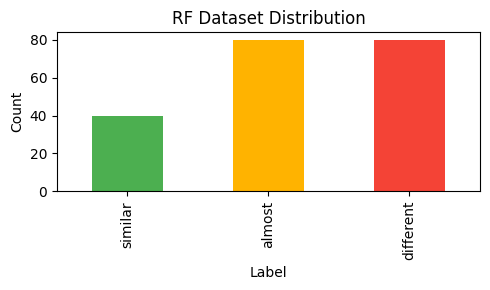

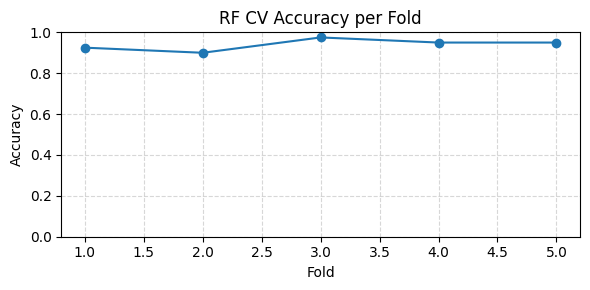

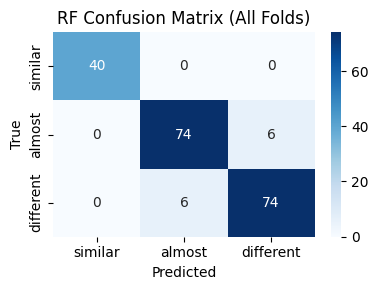

C:\Users\Thanh No\AppData\Local\Temp\ipykernel_22068\3325704124.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_cols, y=importances, palette='viridis')


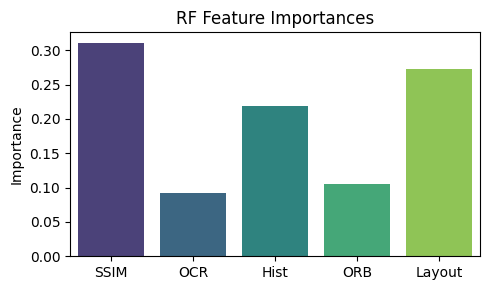

In [ ]:
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from sklearn.metrics import confusion_matrix, accuracy_score

def build_feature_df_rf(model, cases, groups):
    rows=[]
    for (a,b,l), g in zip(cases, groups):
        f = model.feat(a,b)
        row = {'SSIM':f[0],'OCR':f[1],'Hist':f[2],'ORB':f[3],'Layout':f[4],
               'label':l,'group':g}
        rows.append(row)
    return pd.DataFrame(rows)

if 'df_rf' not in globals():
    df_rf = build_feature_df_rf(rf_model, cases, groups)

label_order = ['similar','almost','different']
feat_cols = ['SSIM','OCR','Hist','ORB','Layout']

plt.figure(figsize=(5,3))
df_rf['label'].value_counts().reindex(label_order).plot(kind='bar', color=['#4caf50','#ffb300','#f44336'])
plt.title('RF Dataset Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

gkf = GroupKFold(n_splits=5)
X_all = df_rf[feat_cols].values
y_all = df_rf['label'].values
accs=[]; all_true=[]; all_pred=[]

for fold,(tr,te) in enumerate(gkf.split(X_all, y_all, groups),1):
    Xtr,Xte = X_all[tr], X_all[te]
    ytr,yte = y_all[tr], y_all[te]

    from sklearn.ensemble import RandomForestClassifier
    rf_fold = RandomForestClassifier(
        n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=2,
        random_state=42, class_weight='balanced', n_jobs=-1
    )
    rf_fold.fit(Xtr, [rf_model.map[l] for l in ytr])
    yp_int = rf_fold.predict(Xte)
    inv_map = {v:k for k,v in rf_model.map.items()}
    yp = [inv_map[i] for i in yp_int]
    accs.append(accuracy_score(yte, yp))
    all_true.extend(yte); all_pred.extend(yp)

plt.figure(figsize=(6,3))
plt.plot(range(1,len(accs)+1), accs, marker='o')
plt.title('RF CV Accuracy per Fold')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.grid(ls='--',alpha=.5)
plt.tight_layout()
plt.show()

cm = confusion_matrix(all_true, all_pred, labels=label_order)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_order, yticklabels=label_order)
plt.title('RF Confusion Matrix (All Folds)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

rf_full = RandomForestClassifier(
    n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=2,
    random_state=42, class_weight='balanced', n_jobs=-1
)
rf_full.fit(X_all, [rf_model.map[l] for l in y_all])
importances = rf_full.feature_importances_
plt.figure(figsize=(5,3))
sns.barplot(x=feat_cols, y=importances, palette='viridis')
plt.title('RF Feature Importances')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()


In [3]:
# def tune_rf_v4_fixed():
#     """Tuning RF parameters với GroupKFold"""
#     print("🌲 RANDOM FOREST PARAMETER TUNING (FIXED)")
#     print("="*50)
    
#     cases, groups = load_cases()
    
#     class FeatureRFTuned(FeatureRandomForest):
#         def __init__(self, n_estimators=100, max_depth=10, min_samples_split=5):
#             super().__init__()
#             self.model = RandomForestClassifier(
#                 n_estimators=n_estimators,
#                 max_depth=max_depth,
#                 min_samples_split=min_samples_split,
#                 min_samples_leaf=2,
#                 class_weight='balanced',
#                 random_state=42,
#                 n_jobs=-1
#             )
    
#     param_combinations = [
#         # Core variations
#         {'n_estimators': 50, 'max_depth': 8, 'min_samples_split': 5},
#         {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 5},  # Original
#         {'n_estimators': 150, 'max_depth': 12, 'min_samples_split': 3},
#         {'n_estimators': 200, 'max_depth': 15, 'min_samples_split': 3},
#         # Depth focus
#         {'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 5},
#         {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 5},
#         {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 5},
#     ]
    
#     best_score = 0
#     best_params = {}
    
#     for params in param_combinations:
#         print(f"\n🧪 Testing: {params}")
        
#         model = FeatureRFTuned(**params)
#         X = [model.feat(a,b) for a,b,l in cases]
#         y = [model.map[l] for _,_,l in cases]
        
#         gkf = GroupKFold(n_splits=3)
#         scores = []
        
#         for train_idx, test_idx in gkf.split(X, y, groups):
#             Xtr = [X[i] for i in train_idx]
#             ytr = [y[i] for i in train_idx]
#             Xte = [X[i] for i in test_idx]
#             yte = [y[i] for i in test_idx]
            
#             model.model.fit(Xtr, ytr)
#             yp = model.model.predict(Xte)
            
#             scores.append((yp == yte).mean())
        
#         avg_score = np.mean(scores)
#         std_score = np.std(scores)
        
#         if avg_score > best_score:
#             best_score = avg_score
#             best_params = params
        
#         print(f"   Score: {avg_score*100:.1f}% ± {std_score*100:.1f}%")
    
#     print(f"\n🏆 BEST RF CONFIG:")
#     print(f"   Parameters: {best_params}")
#     print(f"   CV Accuracy: {best_score*100:.1f}%")
    
#     return best_params

# best_rf_params_fixed = tune_rf_v4_fixed()